# Model Calibration

In [2]:
import household_contact_tracing.BranchingProcessSimulation as hct
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
import seaborn as sns
import pandas as pd
import pickle
from patsy import dmatrices
import statsmodels as sm
import statsmodels.api as sma
sns.set()

In [5]:
def solve_for_x(y, res):
    """
    Used when getting parameters from a linear equation
    """
    c = res.params[0]
    m = res.params[1]
    
    return (y - c) / m

There are a large number of parameters that can be calibrated - we primarily are calibrating to the growth rate, however we have the ability to calibrate to a household secondary attack rate and corresponding growth rate.


Importantly this is the notebook that creates the calibration dictionary.

## Growth Rates

We prefer to tune our model to a given growth rate, without contact tracing. The growth rate depends upon a (hazard_rate_cale, infection_reporting_prob) pair and we use the simulation script "Simulate_growth_rates.py" to perform the growth rate simulations and return a data frame of the outputs. We analyse this data frame here.

In [8]:
data = pd.read_excel("../../Data/Calibration/growth_rates.xlsx", index_col = 0)
days_simulated = 20

In [10]:
data

,haz_rate_scale,infection_reporting_prob,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19
0,0.20,0.1,1000,1002,1059,1258,1613,2192,2896,3751,...,7607,9519,11836,14763,18266,22675,27964,34483,42554,52443
1,0.20,0.2,1000,1005,1064,1260,1622,2183,2898,3754,...,7383,9253,11363,14081,17302,21220,25989,31889,39083,47896
2,0.20,0.3,1000,1003,1071,1266,1632,2234,2937,3729,...,7114,8760,10800,13182,16208,19718,23974,29161,35554,43132
3,0.20,0.4,1000,1004,1064,1275,1642,2164,2844,3603,...,6844,8444,10394,12691,15467,18814,22843,27690,33557,40649
4,0.20,0.5,1000,1003,1060,1244,1617,2181,2861,3604,...,6739,8272,10016,12101,14684,17654,21239,25604,30715,36887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.25,0.1,1000,1007,1097,1352,1827,2573,3500,4686,...,10442,13573,17531,22658,29353,37794,48698,62797,80871,104005
246,0.25,0.2,1000,1002,1059,1293,1728,2373,3234,4259,...,9470,12275,15766,20200,26063,33489,43025,54938,70294,89902
247,0.25,0.3,1000,1006,1073,1305,1748,2448,3403,4538,...,9682,12478,16079,20640,26412,33636,42867,54455,69370,88277
248,0.25,0.4,1000,1001,1066,1308,1760,2473,3340,4513,...,9559,12262,15710,19998,25382,32168,40735,51557,65368,82493


## Estimation of Growth Rates:

We fit a linear model to the epidemics and estimate the growth rate of the epidemic.

In [11]:
infection_counts = [str(i) for i in range(days_simulated)]
number_rows = data.shape[0]

In [12]:
data_subset = data[infection_counts]

In [13]:
growth_rates = []

for _ in range(data_subset.shape[0]):
    
    # Which row are we estiamting growth rate for
    print(f"current fit; {_}", end = "\r")
    
    # Difference the counts to get the incidence, take the log to get to the growth rate
    log_diff = data_subset.iloc[_].diff(1).apply(lambda x: np.log(x))

    # temporary dataframe to pass to the linear model
    data_set_up = {
        "log_case_incidence": log_diff[10:days_simulated],
        "time": list(range(10, days_simulated))
    }
    dataframe = pd.DataFrame(data_set_up)

    # Set up the regression
    y, X = dmatrices('log_case_incidence ~ time', 
                     data = dataframe)
    model = sma.RLM(y, X)
    res = model.fit()
    growth_rates.append(res.params[1])

    # Unable to handle missing data, where the epidemic has died out for example
    if res.params[1] == -float("inf"):
        print(f"missing data in line {_}")

current fit; 249

In [14]:
growth_rate_data =pd.DataFrame({
    "growth_rate": growth_rates,
    "infection_reporting_prob": data["infection_reporting_prob"],
    "hazard_rate_scale": data["haz_rate_scale"]
})

In [15]:
y, X = dmatrices('growth_rate ~ hazard_rate_scale + infection_reporting_prob', 
                 data = growth_rate_data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

OLS Regression Results                            
Dep. Variable:            growth_rate   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.172e+04
Date:                Tue, 11 Aug 2020   Prob (F-statistic):          1.83e-245
Time:                        13:05:21   Log-Likelihood:                 1240.6
No. Observations:                 250   AIC:                            -2475.
Df Residuals:                     247   BIC:                            -2465.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0283      0.002     1

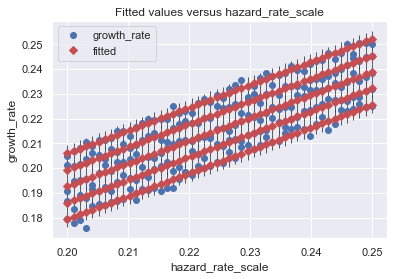

In [16]:
fig = sm.graphics.regressionplots.plot_fit(res, 1)

In [24]:
def solve_for_hazard_rate(results, infection_report_prob, growth_rate):
    """
    Sovles for the required hazard rate from the regression data.
    """
    intercept = res.params[0]
    beta_0 = res.params[1]
    beta_1 = res.params[2]
    hazard_rate_scale = (growth_rate - intercept - beta_1 * infection_report_prob) / beta_0
    return hazard_rate_scale

In [25]:
hazard_rate_getter = lambda infection_report_prob: solve_for_hazard_rate(res, infection_report_prob = infection_report_prob, growth_rate = 0.22)

In [26]:
infection_detect_probs = [0.1, 0.2, 0.3, 0.4, 0.5]
hazard_rates = map(hazard_rate_getter, infection_detect_probs)
hazard_rate_detection_prob_pairs = dict(zip(infection_detect_probs, hazard_rates))

In [27]:
hazard_rate_detection_prob_pairs

{0.1: 0.21523276281929113,
 0.2: 0.22242098020187517,
 0.3: 0.2296091975844592,
 0.4: 0.2367974149670432,
 0.5: 0.24398563234962722}

In [52]:
with open('../../Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'wb') as handle:
    pickle.dump(hazard_rate_detection_prob_pairs, handle, protocol=pickle.HIGHEST_PROTOCOL)

To load the data use the following:

In [53]:
with open('../../Data/Calibration/hazard_rate_detection_prob_pairs.pickle', 'rb') as handle:
    pairs_dict = pickle.load(handle)


## Calibrating the household secondary attack rate

The following code estimates the household secondary attack rate for a given hazard rate scale by simulating the within household epidemics. The number of simulations performed is equal to the starting_infections value.

In [36]:
model_calibrator = hct.model_calibration(haz_rate_scale = 0,
                                         household_haz_rate_scale = 0.77729,
                                         contact_tracing_success_prob = 2/3,
                                         overdispersion = 0.36,
                                         infection_reporting_prob = 0.2,
                                         contact_trace_delay_par = 3,
                                         contact_trace = False,
                                         reduce_contacts_by = 0,
                                         starting_infections = 2000)

In [37]:
%%time
model_calibrator.estimate_secondary_attack_rate()

Wall time: 23.9 s


0.2724783204016431

To estimate the household secondary attack rate, model calibrator simulates the local epidemics, which is very cheap to do

In [38]:
x = np.linspace(0, 14) 
y = list(map(hct.weibull_pdf, x))

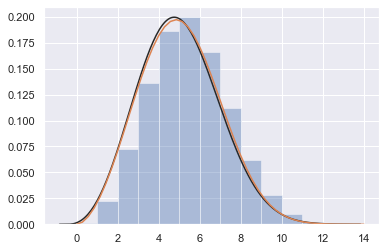

In [39]:
serial_intervals = [node.serial_interval for node in model_calibrator.nodes.all_nodes() if node.generation == 1]
sns.distplot(serial_intervals, bins = range(14), kde = False, fit = ss.exponweib)
plt.plot(x, y)


In [40]:
%%time
secondary_attack_rates = []
for x in np.linspace(0.7, 0.9):
    print(x, end = "\r")
    model_calibrator = hct.model_calibration(haz_rate_scale = 0,
                                            household_haz_rate_scale=x,
                                            contact_tracing_success_prob = 2/3,
                                            overdispersion = 0.36,
                                            infection_reporting_prob = 0.2,
                                            contact_trace_delay_par = 3,
                                            contact_trace = False,
                                            reduce_contacts_by = 0,
                                            starting_infections = 1000)
    secondary_attack_rates.append(model_calibrator.estimate_secondary_attack_rate())
    
data = pd.DataFrame({"household_hazard_rate_scale": np.linspace(0.7, 0.9),
                     "secondary_attack_rate": secondary_attack_rates})

SyntaxError: invalid syntax (<unknown>, line 5)

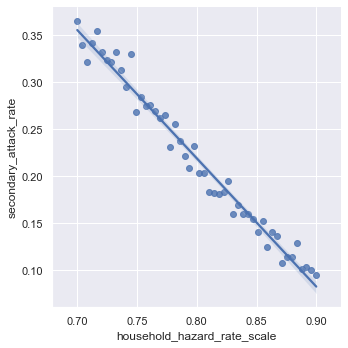

In [93]:
sns.lmplot("household_hazard_rate_scale", "secondary_attack_rate", data = data)

In [94]:
y, X = dmatrices('secondary_attack_rate ~ household_hazard_rate_scale', 
                 data = data)
model_1 = sma.OLS(y, X)
res = model_1.fit()
print(res.summary())

                              OLS Regression Results                             
Dep. Variable:     secondary_attack_rate   R-squared:                       0.976
Model:                               OLS   Adj. R-squared:                  0.975
Method:                    Least Squares   F-statistic:                     1935.
Date:                   Fri, 22 May 2020   Prob (F-statistic):           1.91e-40
Time:                           15:09:27   Log-Likelihood:                 147.49
No. Observations:                     50   AIC:                            -291.0
Df Residuals:                         48   BIC:                            -287.2
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

In [95]:
solve_for_x(0.25, res)

0.7772925726183819

A secondary household attack rate of 25% requires the hazard rate scaling to be around 0.77